Tensorflow type code

In [1]:
# importing the yfinance package
import yfinance as yf

# giving the start and end dates
startDate = '2015-03-01'
endDate = '2017-03-01'

# setting the ticker value
ticker = 'AAPL'

# downloading the data of the ticker value between
# the start and end dates
resultData = yf.download(ticker)

# printing the last 5 rows of the data
print(resultData.tail())

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-07-13  190.500000  191.190002  189.779999  190.539993  190.539993   
2023-07-14  190.229996  191.179993  189.630005  190.690002  190.690002   
2023-07-17  191.899994  194.320007  191.809998  193.990005  193.990005   
2023-07-18  193.350006  194.330002  192.419998  193.729996  193.729996   
2023-07-19  193.100006  198.220001  192.649994  195.300003  195.300003   

              Volume  
Date                  
2023-07-13  41342300  
2023-07-14  41573900  
2023-07-17  50520200  
2023-07-18  48288200  
2023-07-19  47588648  


In [2]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [3]:
df = resultData['Close']

In [ ]:
df

Date
1980-12-12      0.128348
1980-12-15      0.121652
1980-12-16      0.112723
1980-12-17      0.115513
1980-12-18      0.118862
                 ...    
2023-07-10    188.610001
2023-07-11    188.080002
2023-07-12    189.770004
2023-07-13    190.539993
2023-07-14    190.690002
Name: Close, Length: 10736, dtype: float64

In [ ]:
import numpy as np
time = np.array(df.index)
series = np.array(df)

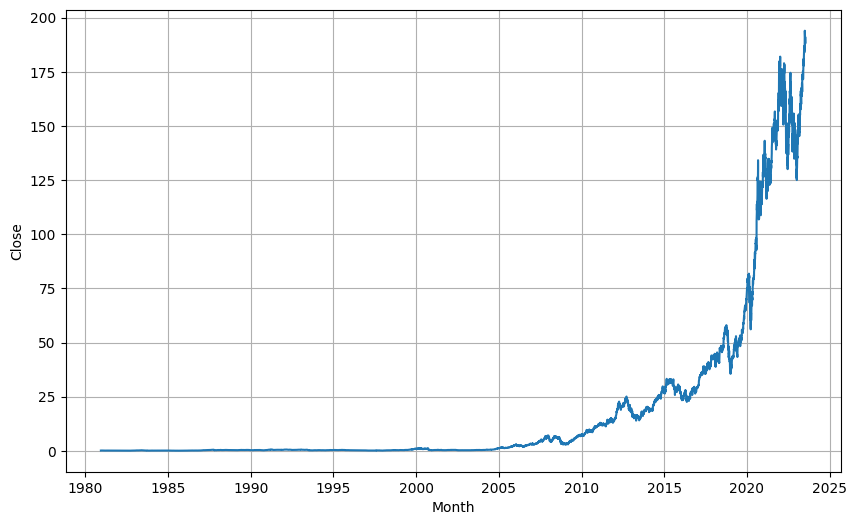

In [ ]:
plot_series(time, series, xlabel='Month', ylabel='Close')

In [ ]:
# Define the split time
split_time = 3000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [ ]:
import tensorflow as tf
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
# Build the model
model = tf.keras.models.Sequential([
  #tf.keras.layers.LSTM(64, return_sequences=True, input_shape=[window_size, 1]),
  #tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu", input_shape=[window_size, 1]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

# Print the model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 30, 30)            60        
                                                                 
 dense_22 (Dense)            (None, 30, 10)            310       
                                                                 
 dense_23 (Dense)            (None, 30, 1)             11        
                                                                 
Total params: 381
Trainable params: 381
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer='nadam')

# Train the model
history = model.fit(train_set, epochs=100)

Epoch 1/100
93/93 [==============================] - 3s 8ms/step - loss: 0.0088
Epoch 2/100
93/93 [==============================] - 1s 10ms/step - loss: 0.0093
Epoch 3/100
93/93 [==============================] - 1s 11ms/step - loss: 0.0097
Epoch 4/100
93/93 [==============================] - 1s 7ms/step - loss: 0.0096
Epoch 5/100
93/93 [==============================] - 1s 7ms/step - loss: 0.0097
Epoch 6/100
93/93 [==============================] - 1s 7ms/step - loss: 0.0099
Epoch 7/100
93/93 [==============================] - 1s 7ms/step - loss: 0.0098
Epoch 8/100
93/93 [==============================] - 1s 7ms/step - loss: 0.0099
Epoch 9/100
93/93 [==============================] - 1s 7ms/step - loss: 0.0100
Epoch 10/100
93/93 [==============================] - 1s 7ms/step - loss: 0.0098
Epoch 11/100
93/93 [==============================] - 1s 7ms/step - loss: 0.0102
Epoch 12/100
93/93 [==============================] - 1s 7ms/step - loss: 0.0101
Epoch 13/100
93/93 [===============

242/242 [==============================] - 2s 8ms/step


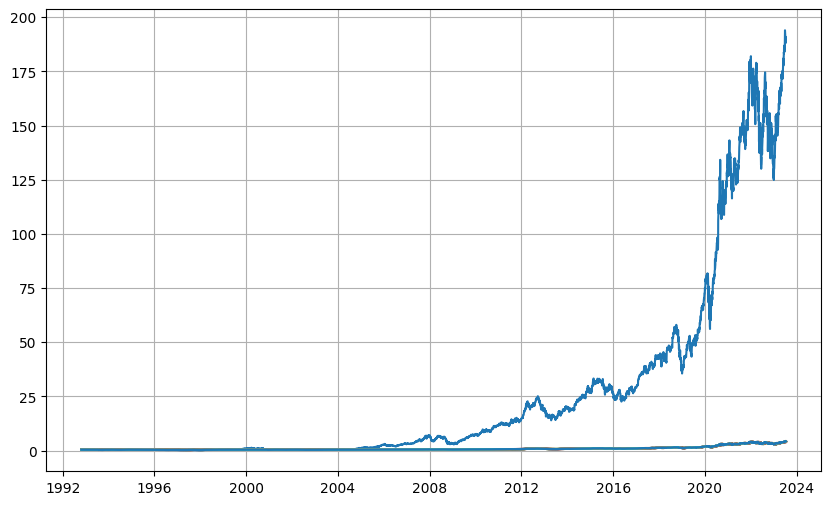

InvalidArgumentError: ignored

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast


# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

In [ ]:
x_valid[0]

0.43526801466941833

In [ ]:
results[0]/x_valid[0]

-521.0962106503238

## Real forecasting

In [ ]:
forecast_series = series[split_time-window_size:split_time]

i = 0
res = []
while i<30:
  forecast = model_forecast(model, forecast_series, window_size, batch_size)
  res.append(forecast[0].item())
  forecast_series = forecast_series[1:]
  forecast_series = np.append(forecast_series,forecast[0])
  i = i+1
res

1/1 [==============================] - 0s 54ms/step


[0.4036252200603485,
 0.4022899568080902,
 0.411432147026062,
 0.4171125590801239,
 0.4189612865447998,
 0.4023911654949188,
 0.4003760516643524,
 0.4013683795928955,
 0.4038934111595154,
 0.40147724747657776,
 0.3913390040397644,
 0.3901117146015167,
 0.3912968337535858,
 0.39370179176330566,
 0.3802642524242401,
 0.3789871633052826,
 0.3862118124961853,
 0.3810616135597229,
 0.3886590600013733,
 0.3879900276660919,
 0.3931206166744232,
 0.38807612657546997,
 0.3843144178390503,
 0.39177292585372925,
 0.3940041959285736,
 0.3862203359603882,
 0.3738904893398285,
 0.38114506006240845,
 0.3848899304866791,
 0.38639336824417114]

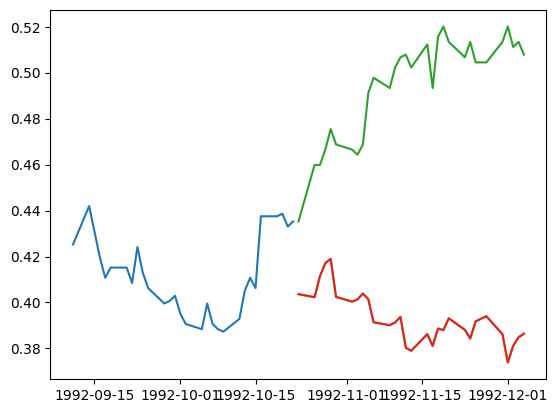

In [ ]:


plt.plot(time_train[-30:], x_train[-30:])
plt.plot(time_valid[:30], res)
plt.plot(time_valid[:30], x_valid[:30])
plt.plot(time_valid[:30], res)
plt.show()

In [ ]:
forecast_series = series[split_time-window_size:split_time]
forecast = model_forecast(model, forecast_series, window_size, batch_size)
forecast = forecast.squeeze()

1/1 [==============================] - 0s 201ms/step


In [ ]:
forecast_series.shape

(30,)

In [ ]:
forecast_series

array([0.42522299, 0.441964  , 0.43080401, 0.41964301, 0.410714  ,
       0.41517901, 0.41517901, 0.40848199, 0.42410699, 0.41294599,
       0.40625   , 0.39955401, 0.40066999, 0.40290201, 0.395089  ,
       0.390625  , 0.38839301, 0.39955401, 0.390625  , 0.38839301,
       0.38727701, 0.39285699, 0.40513399, 0.410714  , 0.40625   ,
       0.4375    , 0.4375    , 0.43861601, 0.433036  , 0.43526801])

In [ ]:
forecast_series = series[split_time-window_size:split_time]
forecast_series = forecast_series[1:]
forecast_series = np.append(forecast_series,1)
print(forecast_series.shape)
forecast_series
print(forecast_series.shape)

(30,)
(30,)


In [ ]:
print(np.append(forecast_series,1))

[0.441964   0.43080401 0.41964301 0.410714   0.41517901 0.41517901
 0.40848199 0.42410699 0.41294599 0.40625    0.39955401 0.40066999
 0.40290201 0.395089   0.390625   0.38839301 0.39955401 0.390625
 0.38839301 0.38727701 0.39285699 0.40513399 0.410714   0.40625
 0.4375     0.4375     0.43861601 0.433036   0.43526801 1.        ]


Hands on ml

In [1]:
# importing the yfinance package
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
import os
from pathlib import Path
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
# giving the start and end dates
startDate = '2015-03-01'
endDate = '2017-03-01'

# setting the ticker value
ticker = 'AAPL'

# downloading the data of the ticker value between
# the start and end dates
resultData = yf.download(ticker)

# printing the last 5 rows of the data
print(resultData.tail())

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-07-13  190.500000  191.190002  189.779999  190.539993  190.539993   
2023-07-14  190.229996  191.179993  189.630005  190.690002  190.690002   
2023-07-17  191.899994  194.320007  191.809998  193.990005  193.990005   
2023-07-18  193.350006  194.330002  192.419998  193.729996  193.729996   
2023-07-19  193.100006  198.220001  192.649994  195.100006  195.100006   

              Volume  
Date                  
2023-07-13  41342300  
2023-07-14  41573900  
2023-07-17  50520200  
2023-07-18  48353800  
2023-07-19  76173882  


In [2]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

In [3]:
df = resultData['Close']
df2 = df.reset_index()['Close']

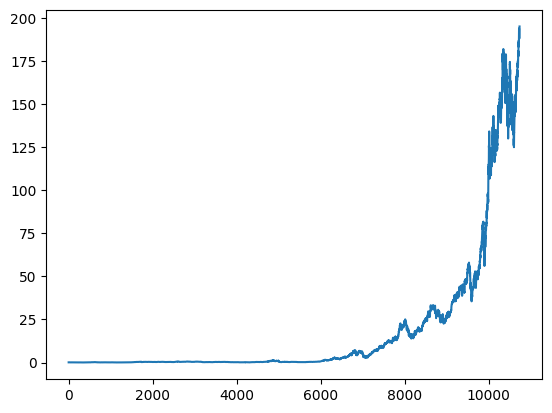

In [4]:
plt.plot(df2)
plt.show()

In [5]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
scaler = MinMaxScaler(feature_range=(0,1))
df2 = scaler.fit_transform(np.array(df2).reshape(-1,1))

In [6]:
df2

array([[4.06258023e-04],
       [3.71928557e-04],
       [3.26150766e-04],
       ...,
       [9.94309175e-01],
       [9.92976139e-01],
       [1.00000000e+00]])

In [7]:
training_size = int(len(df2)*0.65)
test_size = len(df2) - training_size
train_data, test_data = df2[:training_size, :], df2[training_size:,:1]

In [8]:
def create_dataset(dataset, time_step = 1):
  dataX, dataY = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i + time_step,0])
  return np.array(dataX), np.array(dataY)

In [9]:
n_steps = 100
time_step = 100
X_train, y_train = create_dataset(train_data, n_steps)
X_test, y_test = create_dataset(test_data, n_steps)

In [10]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)

In [11]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

#Computing Some Baselines

naive prediction. Basically the forecast is the previous time step value

In [13]:
y_pred = X_test[:,-1]
np.mean(keras.losses.mean_squared_error(y_test, y_pred))

5.099390764702942e-05

Simple NN model

In [14]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[time_step,1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_test, y_test))

Epoch 1/20
215/215 [==============================] - 6s 4ms/step - loss: 3.0029e-06 - val_loss: 7.2728e-04
Epoch 2/20
215/215 [==============================] - 1s 4ms/step - loss: 6.1674e-07 - val_loss: 6.0247e-04
Epoch 3/20
215/215 [==============================] - 1s 4ms/step - loss: 5.2519e-07 - val_loss: 5.9299e-04
Epoch 4/20
215/215 [==============================] - 1s 4ms/step - loss: 5.4357e-07 - val_loss: 4.8318e-04
Epoch 5/20
215/215 [==============================] - 1s 3ms/step - loss: 4.2559e-07 - val_loss: 4.0744e-04
Epoch 6/20
215/215 [==============================] - 1s 4ms/step - loss: 3.7806e-07 - val_loss: 6.2595e-04
Epoch 7/20
215/215 [==============================] - 1s 3ms/step - loss: 3.8277e-07 - val_loss: 4.8572e-04
Epoch 8/20
215/215 [==============================] - 1s 5ms/step - loss: 3.4689e-07 - val_loss: 5.2244e-04
Epoch 9/20
215/215 [==============================] - 1s 5ms/step - loss: 3.2235e-07 - val_loss: 6.4431e-04
Epoch 10/20
215/215 [=======

In [15]:
model.evaluate(X_test, y_test)

115/115 [==============================] - 0s 2ms/step - loss: 3.2747e-04


0.0003274727496318519

115/115 [==============================] - 0s 1ms/step


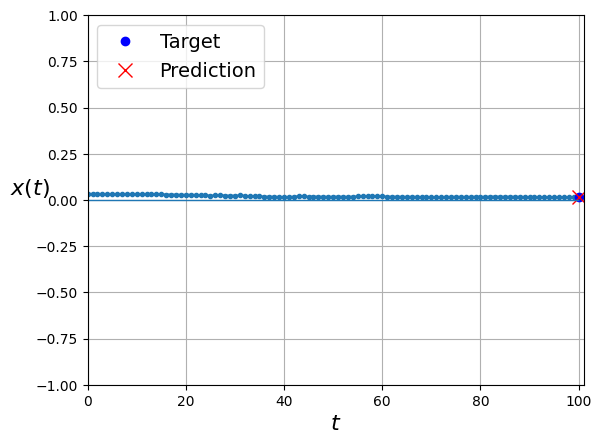

In [16]:
y_pred = model.predict(X_test)
plot_series(X_test[0, :, 0], y_test[0, 0], y_pred[0, 0])
plt.show()

Simple RNN

In [17]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_test, y_test))

Epoch 1/20
215/215 [==============================] - 18s 78ms/step - loss: 7.2355e-04 - val_loss: 0.0439
Epoch 2/20
215/215 [==============================] - 16s 72ms/step - loss: 1.2205e-06 - val_loss: 0.0254
Epoch 3/20
215/215 [==============================] - 16s 73ms/step - loss: 3.1645e-07 - val_loss: 0.0252
Epoch 4/20
215/215 [==============================] - 16s 76ms/step - loss: 3.2238e-07 - val_loss: 0.0252
Epoch 5/20
215/215 [==============================] - 16s 75ms/step - loss: 3.2711e-07 - val_loss: 0.0250
Epoch 6/20
215/215 [==============================] - 16s 75ms/step - loss: 3.3142e-07 - val_loss: 0.0253
Epoch 7/20
215/215 [==============================] - 16s 75ms/step - loss: 3.3029e-07 - val_loss: 0.0251
Epoch 8/20
215/215 [==============================] - 16s 75ms/step - loss: 3.7129e-07 - val_loss: 0.0250
Epoch 9/20
215/215 [==============================] - 16s 72ms/step - loss: 3.4578e-07 - val_loss: 0.0249
Epoch 10/20
215/215 [=========================

In [18]:
model.evaluate(X_test, y_test)

115/115 [==============================] - 1s 10ms/step - loss: 0.0244


0.024419765919446945

115/115 [==============================] - 1s 10ms/step


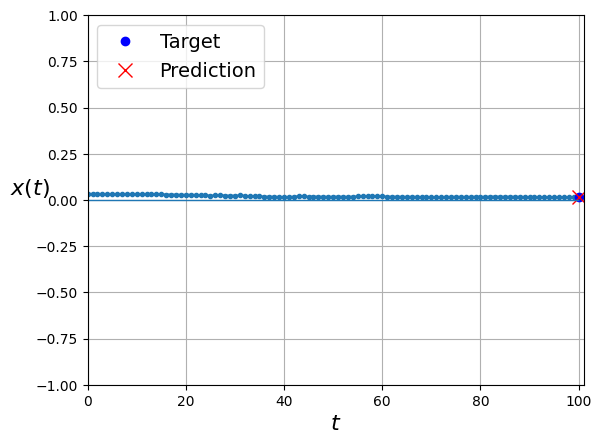

In [19]:
y_pred = model.predict(X_test)
plot_series(X_test[0, :, 0], y_test[0, 0], y_pred[0, 0])
plt.show()

Deep RNNs

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_test, y_test))

Epoch 1/20
215/215 [==============================] - 72s 314ms/step - loss: 0.0042 - val_loss: 0.1192
Epoch 2/20
215/215 [==============================] - 68s 316ms/step - loss: 5.3914e-06 - val_loss: 0.1188
Epoch 3/20
215/215 [==============================] - 65s 300ms/step - loss: 5.1163e-06 - val_loss: 0.1199
Epoch 4/20
215/215 [==============================] - 66s 309ms/step - loss: 5.2082e-06 - val_loss: 0.1215
Epoch 5/20
215/215 [==============================] - 69s 319ms/step - loss: 7.0051e-06 - val_loss: 0.1248
Epoch 6/20
215/215 [==============================] - 72s 336ms/step - loss: 6.8415e-06 - val_loss: 0.1274
Epoch 7/20
215/215 [==============================] - 68s 314ms/step - loss: 5.5268e-06 - val_loss: 0.1298
Epoch 8/20
215/215 [==============================] - 67s 311ms/step - loss: 3.9545e-06 - val_loss: 0.1312
Epoch 9/20
215/215 [==============================] - 66s 305ms/step - loss: 3.7633e-06 - val_loss: 0.1316
Epoch 10/20
215/215 [====================

In [21]:
model.evaluate(X_test, y_test)

115/115 [==============================] - 4s 33ms/step - loss: 0.1035


0.10354696214199066

115/115 [==============================] - 3s 25ms/step


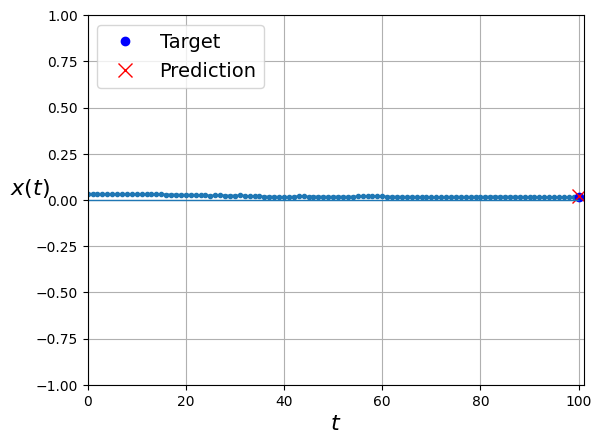

In [22]:
y_pred = model.predict(X_test)
plot_series(X_test[0, :, 0], y_test[0, 0], y_pred[0, 0])
plt.show()

Forecasting Several Steps Ahead

In [23]:
X = X_train[-1:,:,:]
Y = y_test[:10]

In [24]:
Y = Y.reshape(1,10,1)
Y.shape

(1, 10, 1)

In [25]:
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 40ms/step


In [26]:
np.mean(keras.metrics.mean_squared_error(Y, Y_pred))

0.00013623960631460597

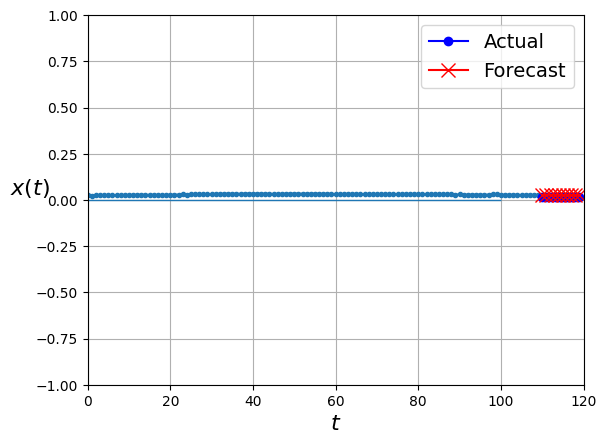

In [27]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X, Y, Y_pred)

plt.show()

In [28]:
X.shape

(1, 110, 1)

In [29]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[100, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_test, y_test))

Epoch 1/20
215/215 [==============================] - 2s 4ms/step - loss: 7.1529e-06 - val_loss: 0.0030
Epoch 2/20
215/215 [==============================] - 1s 3ms/step - loss: 1.8464e-06 - val_loss: 0.0015
Epoch 3/20
215/215 [==============================] - 1s 3ms/step - loss: 1.1131e-06 - val_loss: 9.3458e-04
Epoch 4/20
215/215 [==============================] - 1s 4ms/step - loss: 8.1641e-07 - val_loss: 0.0011
Epoch 5/20
215/215 [==============================] - 1s 3ms/step - loss: 6.1385e-07 - val_loss: 6.8973e-04
Epoch 6/20
215/215 [==============================] - 1s 4ms/step - loss: 5.2763e-07 - val_loss: 5.6487e-04
Epoch 7/20
215/215 [==============================] - 1s 5ms/step - loss: 4.4854e-07 - val_loss: 5.8670e-04
Epoch 8/20
215/215 [==============================] - 1s 5ms/step - loss: 3.9300e-07 - val_loss: 4.3346e-04
Epoch 9/20
215/215 [==============================] - 1s 4ms/step - loss: 3.6470e-07 - val_loss: 6.1866e-04
Epoch 10/20
215/215 [===================

In [37]:
y_train

array([[0.00038337],
       [0.00038909],
       [0.00037479],
       ...,
       [0.02981182],
       [0.02969829],
       [0.03079324]])

In [49]:
Y = y_train.copy()

In [50]:
Y = Y.squeeze()

In [52]:
Y = Y.tolist()

In [53]:
Y.extend(y_test[:10].squeeze().tolist())

In [56]:
dataY = []
for i in range(len(Y) - 10):
  dataY.append(np.array(Y[i:i+10]))

In [59]:
dataY = np.array(dataY)
dataY.shape

(6879, 10)

In [61]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[100, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, dataY, epochs=20)

Epoch 1/20
215/215 [==============================] - 5s 3ms/step - loss: 1.1232e-05
Epoch 2/20
215/215 [==============================] - 1s 3ms/step - loss: 1.5862e-06
Epoch 3/20
215/215 [==============================] - 1s 4ms/step - loss: 1.2166e-06
Epoch 4/20
215/215 [==============================] - 1s 4ms/step - loss: 1.0232e-06
Epoch 5/20
215/215 [==============================] - 1s 4ms/step - loss: 9.0945e-07
Epoch 6/20
215/215 [==============================] - 1s 3ms/step - loss: 8.4529e-07
Epoch 7/20
215/215 [==============================] - 1s 3ms/step - loss: 7.8604e-07
Epoch 8/20
215/215 [==============================] - 1s 3ms/step - loss: 7.5543e-07
Epoch 9/20
215/215 [==============================] - 1s 3ms/step - loss: 7.1015e-07
Epoch 10/20
215/215 [==============================] - 1s 3ms/step - loss: 7.0030e-07
Epoch 11/20
215/215 [==============================] - 1s 3ms/step - loss: 6.9980e-07
Epoch 12/20
215/215 [==============================] - 1s 3ms/s

In [68]:
Y_pred = model.predict(X_train[-1:])[..., np.newaxis]

1/1 [==============================] - 0s 119ms/step


In [70]:
y_test[:10]

array([[0.01706606],
       [0.01678042],
       [0.01641238],
       [0.01672183],
       [0.01633365],
       [0.0159821 ],
       [0.01580815],
       [0.01537236],
       [0.01501531],
       [0.01482305]])

In [72]:
Y_pred

array([[[0.02783754],
        [0.02907717],
        [0.02952878],
        [0.02893577],
        [0.02674415],
        [0.02892933],
        [0.02949576],
        [0.02871871],
        [0.02942772],
        [0.02718883]]], dtype=float32)

In [79]:
Y_pred = model.predict(X_test[0].reshape(1,100,1))[..., np.newaxis]

1/1 [==============================] - 0s 29ms/step
